# Motivation for the Image Classification Project with the Chessman Image Dataset
### Problem Statement:

Chess is a game of strategy that has been enjoyed for centuries. Recognizing and categorizing chess pieces is a fundamental task for both human players and automated systems. With the rise of digital and online chess platforms, there is a growing need for automated systems that can accurately identify and classify chess pieces from images. This capability can enhance digital chess experiences, improve the development of chess-playing robots, and contribute to computer vision research.

### End Users:
*   Online Chess Platforms: Companies that provide digital chess games and educational tools.
*   Developers of Chess-Playing Robots: Engineers and researchers working on physical robots that play chess.
*   Computer Vision Researchers: Academics and professionals focused on advancing image recognition technologies.


### Goal of End Users:
Online Chess Platforms: Enhance user experience by integrating automated piece recognition, allowing players to set up physical boards that the system can digitize.
Developers of Chess-Playing Robots: Enable robots to accurately identify and move pieces on a physical chessboard, improving their ability to compete against human opponents.
Computer Vision Researchers: Use the project as a case study to test and improve image classification algorithms.

### Obstacle to be Solved:

The main challenge is achieving high accuracy in classifying chess pieces despite variations in image quality, lighting conditions, and angles. Chess pieces can appear very similar to each other, and distinguishing between them requires a robust image classification model. The project aims to overcome these obstacles by leveraging data augmentation techniques and advanced machine learning models.


# Data Collection and Augmentation

### Dataset
https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset

### Splitting Images
I will classify six classes:


*   Bishop
*   King

*   Knight
*   Pawn

*   Queen
*   Rook

I do this by creating different sub folders in the project, which then will be accessed in the script.

### Augmentation
By flipping the images randomly on the horizontal side, we can try to get a better result.


### Models
https://keras.io/api/applications/








In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%pip install --upgrade tensorflow

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/Library/

In [31]:
import tensorflow as tf
tf.__version__

'2.16.1'

In [32]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [33]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='images/train',
  labels='inferred',
  label_mode='int', # !!! ‘categorical' when using sparse_categorical_crossentropy loss !!!
  batch_size=12,
  image_size=(150, 150))

validation_ds = tf.keras.utils.image_dataset_from_directory(
  directory='images/val',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))

Found 423 files belonging to 6 classes.
Found 129 files belonging to 6 classes.


In [34]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [35]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 36
Number of validation batches: 9
Number of test batches: 2


2024-05-20 16:36:27.461767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


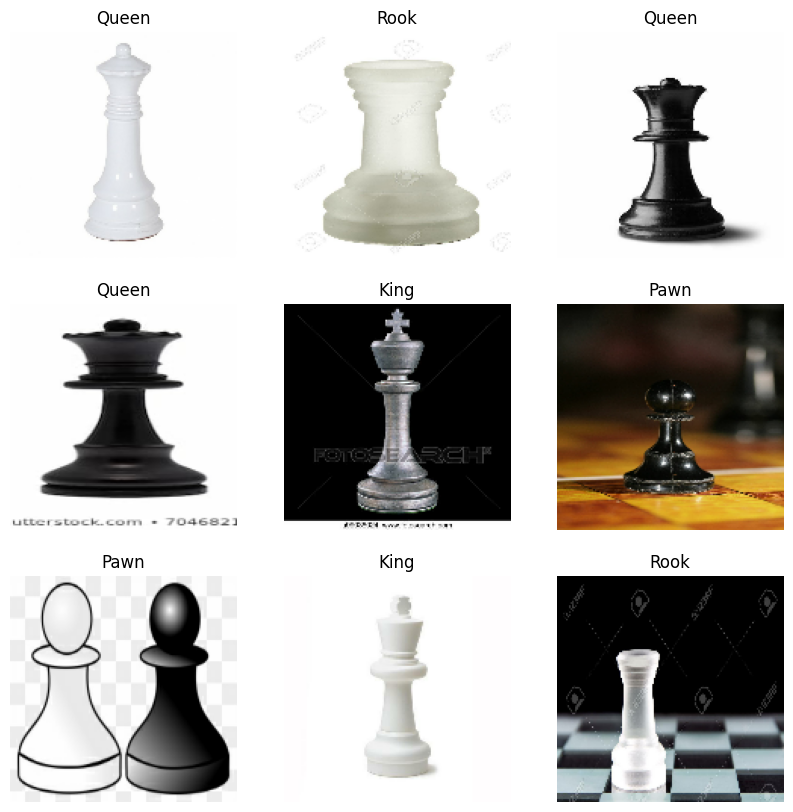

In [36]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
number_of_classes = len(train_ds.class_names)

In [37]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [38]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),                      # Random zoom by up to 20%
    layers.RandomContrast(0.2),                  # Randomly adjust contrast by up to 20%
    layers.RandomBrightness(0.2),                # Randomly adjust brightness by up to 20%
    layers.GaussianNoise(0.1),                   # Add Gaussian noise
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

2024-05-20 16:36:35.968093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


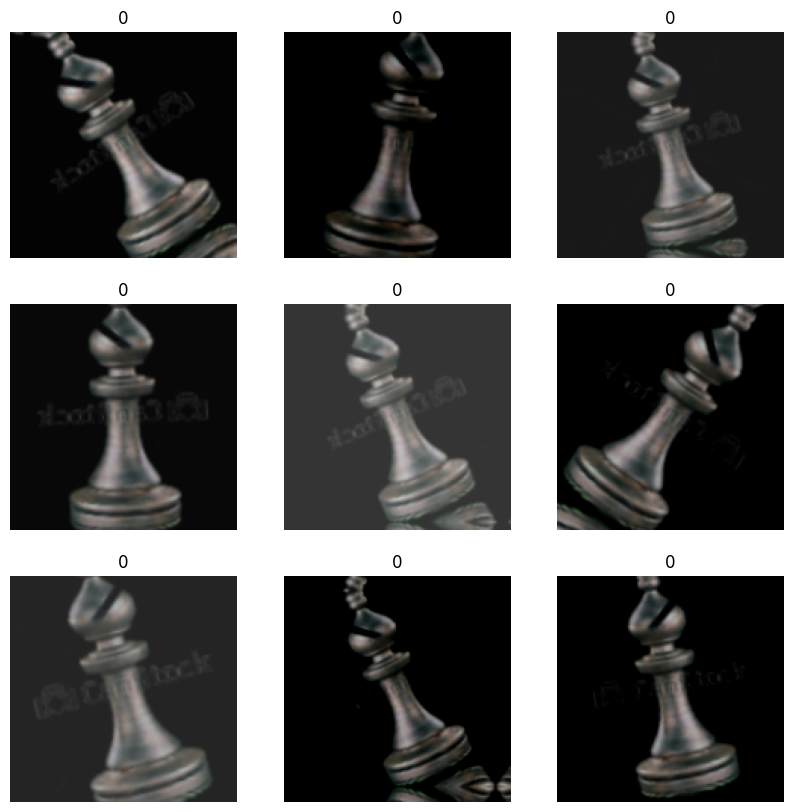

In [39]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


### Base Model Xception
---



In [51]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_8 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_3 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_3  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 6)             │     12,294 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,873,774 (79.63 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [52]:
model.compile(optimizer=keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 8
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.2546 - loss: 1.8589 - val_accuracy: 0.3714 - val_loss: 1.5086
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.5036 - loss: 1.3565 - val_accuracy: 0.5048 - val_loss: 1.3618
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.5938 - loss: 1.1324 - val_accuracy: 0.5333 - val_loss: 1.2431
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.6209 - loss: 1.0300 - val_accuracy: 0.5333 - val_loss: 1.1896
Epoch 5/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.5945 - loss: 0.9904 - val_accuracy: 0.5714 - val_loss: 1.1958
Epoch 6/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.6400 - loss: 0.9321 - val_accuracy: 0.6476 - val_loss: 1.0726
Epoch 7/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.7221 - loss: 0.7852 - val_accuracy: 0.6571 - val_loss: 1.0313
Epoch 8/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.6984 - los

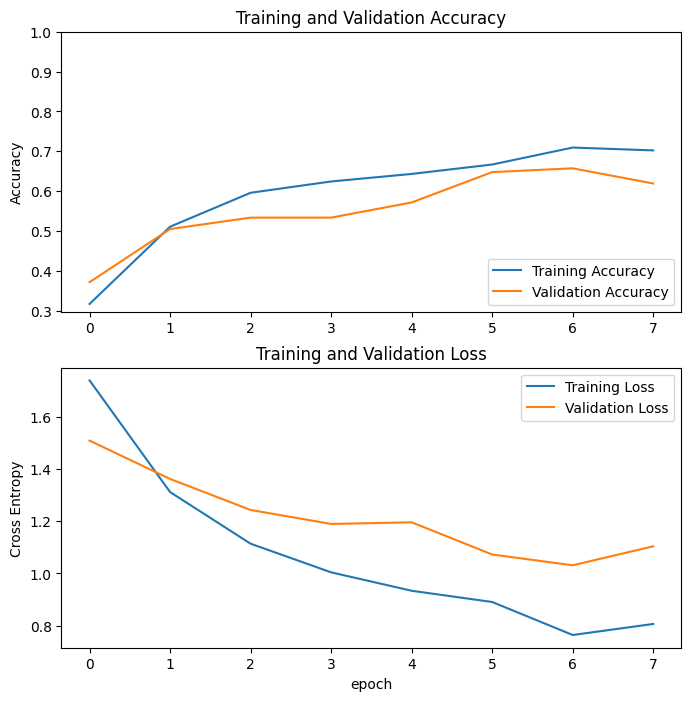

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
print("Test dataset evaluation before unfreeze")
model.evaluate(test_ds)

Test dataset evaluation before unfreeze
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.5833 - loss: 1.3199


[1.3305789232254028, 0.5416666865348816]

In [55]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_8 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_3 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_3  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 6)             │     12,294 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,898,364 (79.72 MB)

 Trainable params: 20,819,246 (79.42 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 24,590 (96.06 KB)

Fitting the end-to-end model
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 849ms/step - accuracy: 0.4581 - loss: 1.4047 - val_accuracy: 0.6571 - val_loss: 1.1038


In [56]:
model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5556 - loss: 1.1687


[1.2731578350067139, 0.5416666865348816]

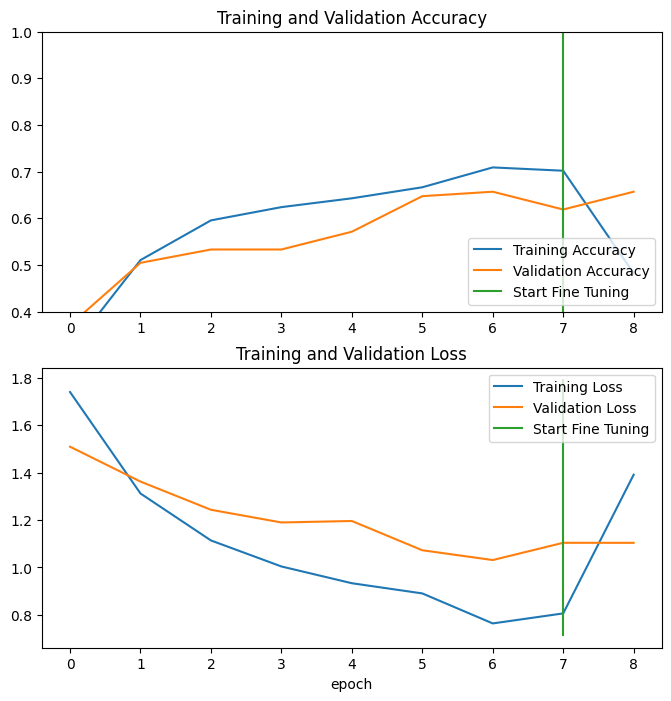

In [57]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) # set the y-axis limits
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
print("Test dataset evaluation after freeze")
model.evaluate(test_ds)

Test dataset evaluation after freeze
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6389 - loss: 1.0254


[1.0029830932617188, 0.6666666865348816]

Predictions:
 [4 1 3 5 4 1 0 2 3 5 5 2]
Labels:
 [0 0 3 1 1 3 0 2 3 5 4 2]


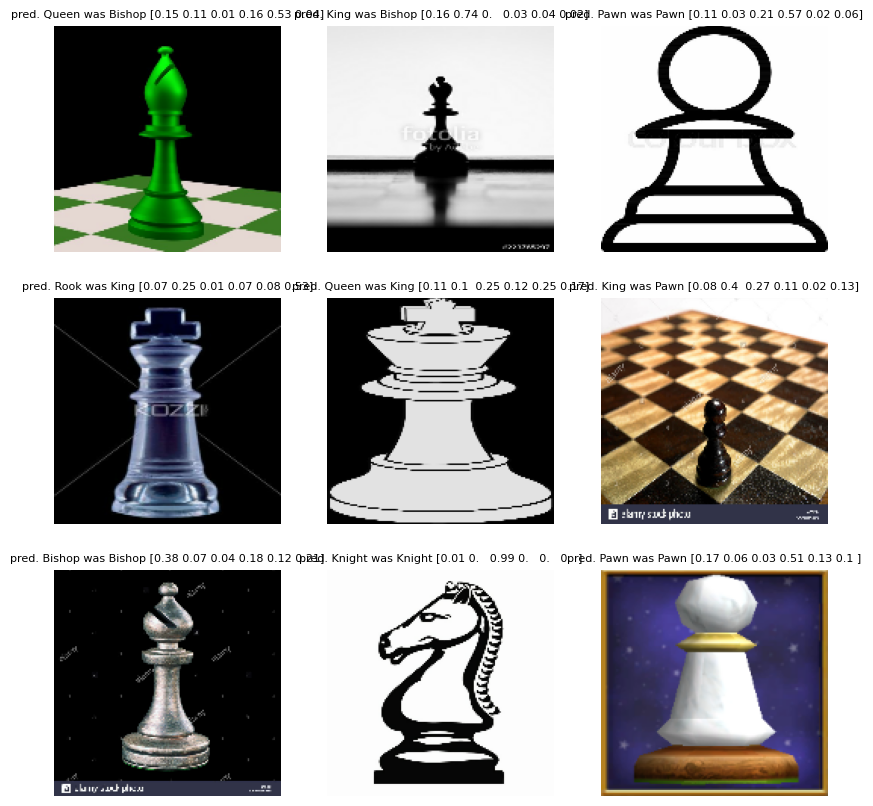

In [59]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[label_batch[i]] + ' ' + 	str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

Now We want to do the same but with a different base model

## Base Model: VGG16
---

In [60]:
base_model_vgg16 = keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model_vgg16.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model_vgg16(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_10 (InputLayer) │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_4 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ vgg16 (Functional)          │ (None, 4, 4, 512)     │ 14,714,688 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_4  │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 6)             │      3,078 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [62]:
model.compile(optimizer=keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 561ms/step - accuracy: 0.2499 - loss: 1.7880 - val_accuracy: 0.2857 - val_loss: 1.7042
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - accuracy: 0.3713 - loss: 1.6667 - val_accuracy: 0.4095 - val_loss: 1.6130
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.3879 - loss: 1.5766 - val_accuracy: 0.5143 - val_loss: 1.5373
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 549ms/step - accuracy: 0.4644 - loss: 1.5080 - val_accuracy: 0.5905 - val_loss: 1.4421


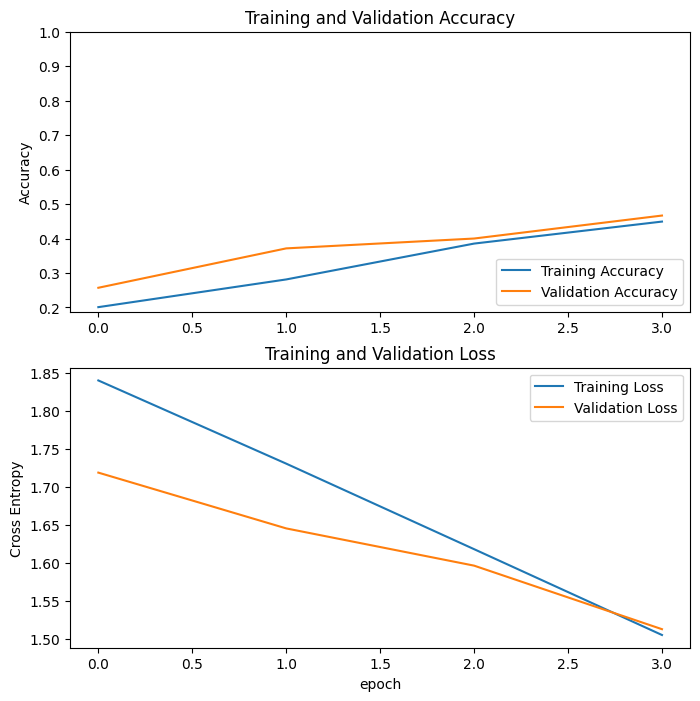

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
print("Test dataset evaluation before unfreeze")
model.evaluate(test_ds)

Test dataset evaluation before unfreeze
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.5556 - loss: 1.4883


[1.4922972917556763, 0.5416666865348816]

In [63]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model_vgg16.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 4
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_10 (InputLayer) │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_4 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ vgg16 (Functional)          │ (None, 4, 4, 512)     │ 14,714,688 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_4  │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 6)             │      3,078 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,723,924 (56.17 MB)

 Trainable params: 14,717,766 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,158 (24.06 KB)

Fitting the end-to-end model
Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5106 - loss: 1.2784 - val_accuracy: 0.6952 - val_loss: 0.8259
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7643 - loss: 0.7024 - val_accuracy: 0.6857 - val_loss: 0.8503
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7517 - loss: 0.6658 - val_accuracy: 0.7048 - val_loss: 0.8220
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8277 - loss: 0.4737 - val_accuracy: 0.7429 - val_loss: 0.6755


In [64]:
model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.6667 - loss: 0.8062


[0.7333908081054688, 0.7083333134651184]

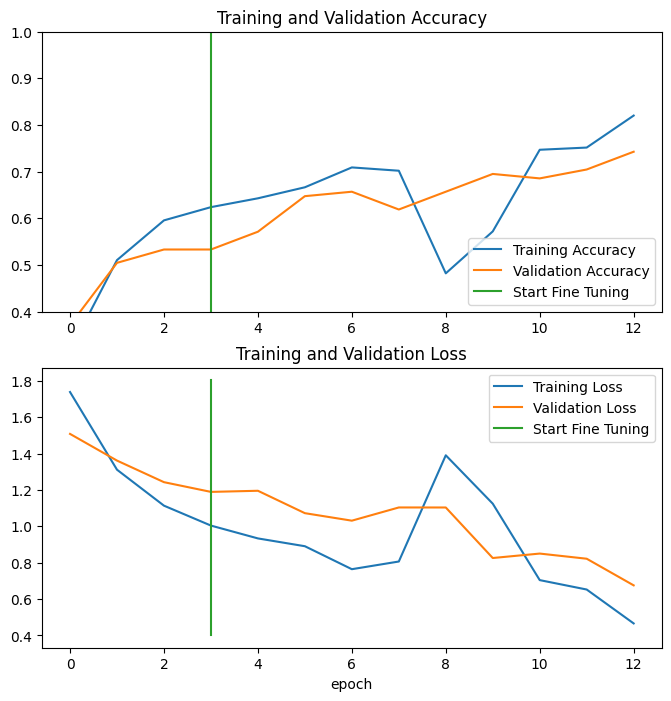

In [65]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) # set the y-axis limits
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [66]:
print("Test dataset evaluation after freeze")
model.evaluate(test_ds)

Test dataset evaluation after freeze
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - accuracy: 0.8889 - loss: 0.4708


[0.5841966271400452, 0.8333333134651184]

Predictions:
 [3 0 0 0 1 5 3 3 5 0 2 0]
Labels:
 [3 0 0 0 1 5 3 4 3 0 2 0]


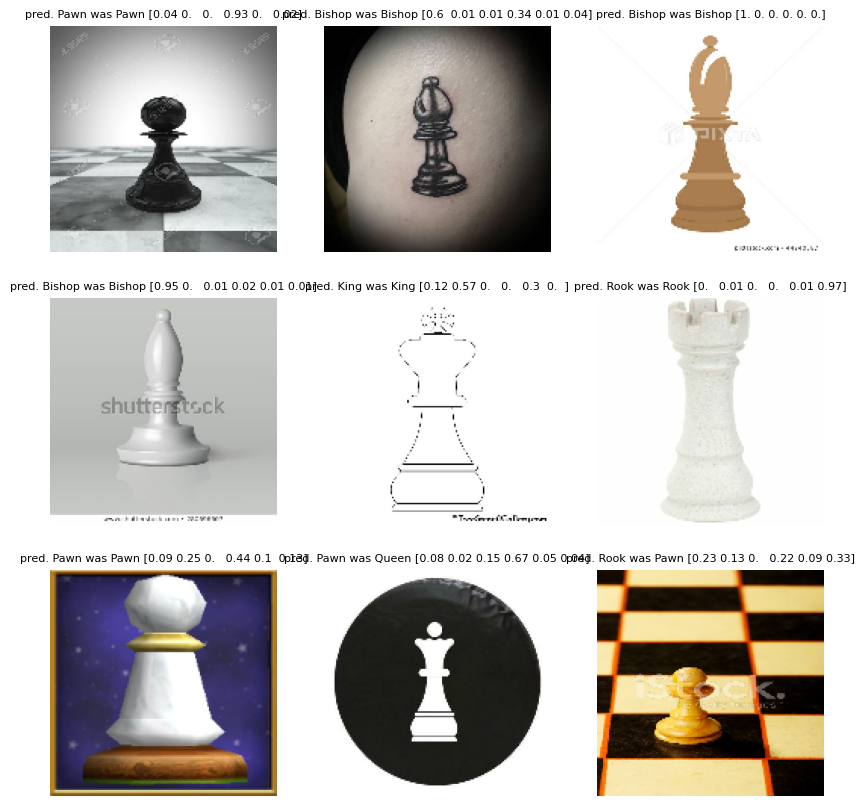

In [67]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[label_batch[i]] + ' ' + 	str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

#Evaluation
##Xception
We clearly see that there is an issue after we start fine-tuning the model:
![Epochs](screenshots/XCeption4Epoch.png)

This is why I decided to do 8 epochs instead, as I think the model needs a few more epochs to stabilize. We had an accuracy of 6.25 before fine-tuning and an accuracy of 0.58 after fine-tuning. As we can see, the result after fine-tuning is not better, but we achieved a better accuracy of 0.66.

##VGG16
Here we can see that the model is performing even better after fine-tuning. This is why I will not increase the number of epochs but will continue fine-tuning. We got an accuracy of 0.625.
![Epochs](screenshots/VGG16Epoch.png)

And WOW! The VGG16 model performed really well after we continued to fine-tune it. Therefore, I will now choose the second model.

We got an accuracy of 0.88

In [68]:
model.save('chess-predict-model_transferlearning.keras')